### **Telecom Churn Prediction**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV,  KFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer # digunakan untuk cek missing Value
from sklearn.preprocessing import RobustScaler, PowerTransformer, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score # Evaluation Matrix
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import category_encoders as ce
from sklearn.ensemble import AdaBoostClassifier,  GradientBoostingClassifier
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('Telco Customer Churn.csv')
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [3]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [4]:
TelcoChurnDesc = []
for i in df.columns:
    TelcoChurnDesc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round(((df[i].isna().sum() / len(df)) * 100), 2),
        df[i].nunique(),
        df[i].drop_duplicates().sample(2).values
    ])

pd.DataFrame(TelcoChurnDesc, columns=[
    "Data Features",
    "Data Types",
    "Null",
    "Null Percentage",
    "Unique",
    "Unique Sample"
])

,Data Features,Data Types,Null,Null Percentage,Unique,Unique Sample
0,customerID,object,0,0.0,7043,"[4536-PLEQY, 3791-LGQCY]"
1,gender,object,0,0.0,2,"[Male, Female]"
2,SeniorCitizen,int64,0,0.0,2,"[0, 1]"
3,Partner,object,0,0.0,2,"[Yes, No]"
4,Dependents,object,0,0.0,2,"[No, Yes]"
5,tenure,int64,0,0.0,73,"[46, 2]"
6,PhoneService,object,0,0.0,2,"[Yes, No]"
7,MultipleLines,object,0,0.0,3,"[No, Yes]"
8,InternetService,object,0,0.0,3,"[No, Fiber optic]"
9,OnlineSecurity,object,0,0.0,3,"[No internet service, No]"


In [5]:
df.Churn.value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [6]:
pd.crosstab(df['Churn'],columns='Persentase Churn',normalize=True)*100 # Balance because the ratio is below 80%

col_0,Persentase Churn
Churn,
No,73.463013
Yes,26.536987


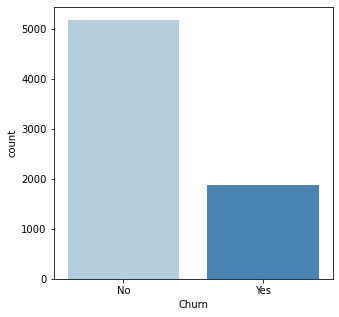

In [7]:
plt.figure(figsize=(5,5))
ax = sns.countplot(x=df['Churn'], palette ='Blues', linewidth = 1)
plt.show()

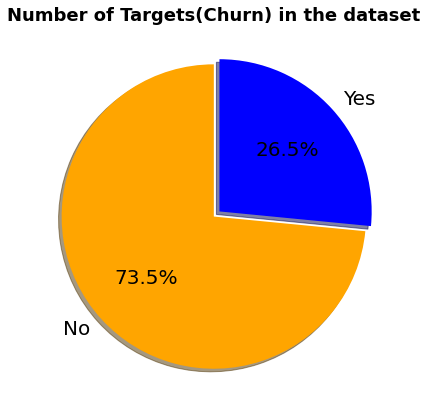

In [8]:
plt.figure(figsize=(7,7))
plt.title("Number of Targets(Churn) in the dataset", size=18, weight='bold')
plt.pie(df['Churn'].value_counts(), explode=(0,0.05), labels=['No', 'Yes'], colors=["orange","blue"], autopct='%1.1f%%', shadow=True, 
        startangle=90, textprops={"fontsize":20})

plt.show()

In [9]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

# Checking Missing Value

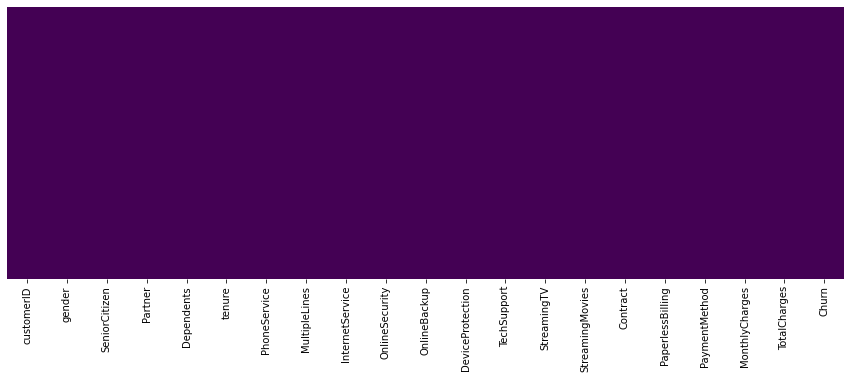

In [10]:
plt.figure(figsize = (15, 5))
sns.heatmap(df.isna(), cmap = 'viridis',yticklabels = False, cbar= False)
plt.show()

In [11]:
df=df[df['TotalCharges']!=' ']

In [12]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors = 'ignore')

In [13]:
11/7043*100 # Di drop baris 

0.1561834445548772

# CEK OUTLIERS

In [14]:
def cek_outliers(tabel,col):
    Q1 = tabel[col].describe()['25%']
    Q3 = tabel[col].describe()['75%']
    IQR = Q3-Q1
    UF = Q3 + (1.5*IQR)
    LF = Q1 - (1.5*IQR)
    tabel_outliers = df[(df[col] < LF) | (df[col] > UF)]
    if len(tabel_outliers) == 0:
           return "No Outliers"
    else:
           return tabel_outliers

In [15]:
cek_outliers(df,'MonthlyCharges')

'No Outliers'

In [16]:
cek_outliers(df,'tenure')

'No Outliers'

In [17]:
cek_outliers(df,'TotalCharges')

'No Outliers'

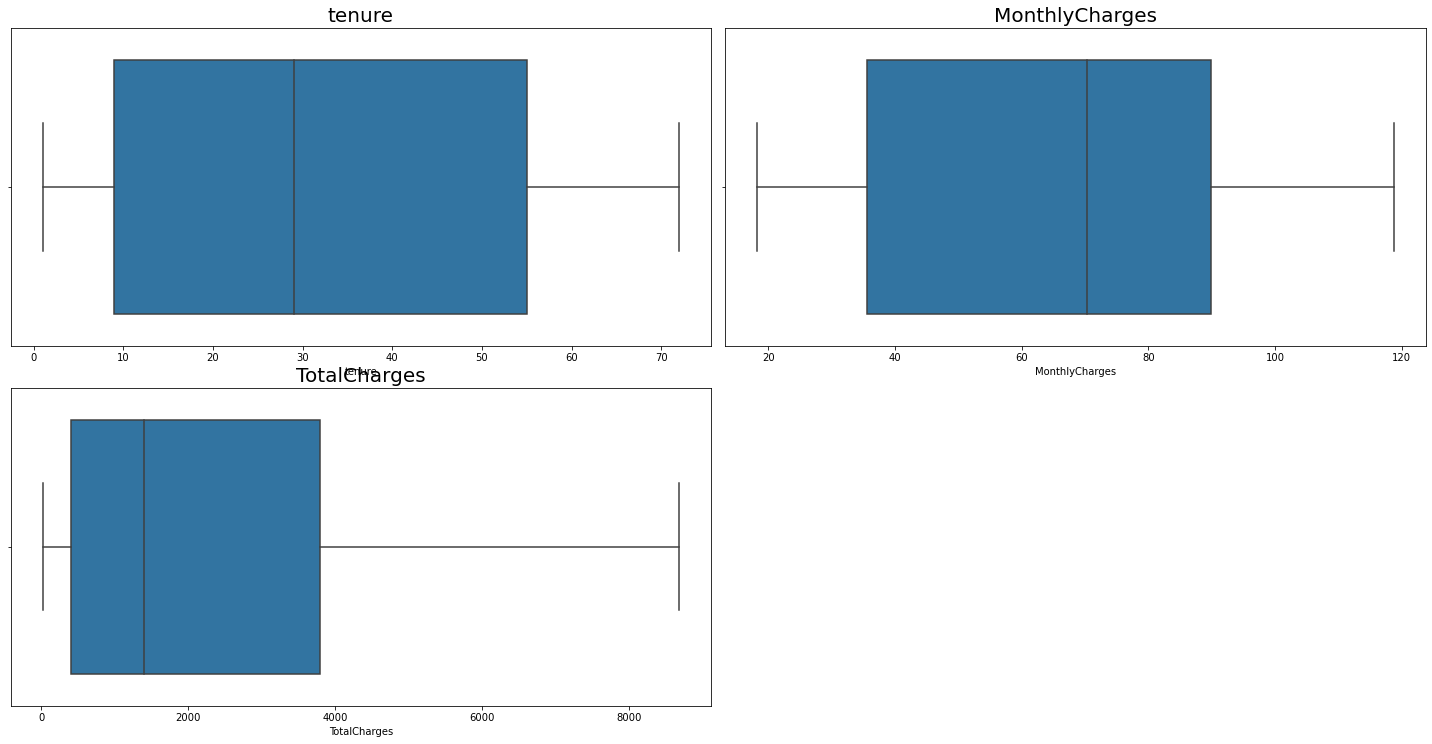

In [18]:
count = 0
fig = plt.figure(figsize=(20,20))

for i in df.drop(columns=['customerID','gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod','Churn']).columns:
    count +=1
    ax= plt.subplot(4,2,count)
    sns.boxplot(df[i])
    fig.tight_layout()
    plt.title(i,fontsize=20)

plt.show()

# TARGET VALUES

In [19]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No':0})

In [20]:
X = df.drop(columns=['Churn', 'customerID'])
y = df['Churn'] 

# Data Splitting and Train-Test Data

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size = .20, random_state = 42) 

Splitting data is done to divide the amount of data that you want to train and test. In testing the data this time I divided 20% of the data for testing and 80% for training.

In [22]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5625 entries, 1413 to 1505
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5625 non-null   object 
 1   SeniorCitizen     5625 non-null   int64  
 2   Partner           5625 non-null   object 
 3   Dependents        5625 non-null   object 
 4   tenure            5625 non-null   int64  
 5   PhoneService      5625 non-null   object 
 6   MultipleLines     5625 non-null   object 
 7   InternetService   5625 non-null   object 
 8   OnlineSecurity    5625 non-null   object 
 9   OnlineBackup      5625 non-null   object 
 10  DeviceProtection  5625 non-null   object 
 11  TechSupport       5625 non-null   object 
 12  StreamingTV       5625 non-null   object 
 13  StreamingMovies   5625 non-null   object 
 14  Contract          5625 non-null   object 
 15  PaperlessBilling  5625 non-null   object 
 16  PaymentMethod     5625 non-null   objec

# PIPELINE

Data is being processed through Pipeline, in order to simplify the process and avoid data leakage. 

First of all the data is grouped into numerical and categorical pipeline based on it's type of data as these two types of data will be treated differently. 
Numbers that goes through numerical pipeline where missing value will be filled with it's mean and all the numbers are scaled using robust scaler where it is scaled based on its quantile range. Categorical type of data's missing value will be filled with its mode / most frequent and they will be encoded using one hot encoder.

Last, it will go to the algorithm pipeline. There are three algorithm that will be used: KNN, Random Forest, XGBoost, and Logistic Regression.

# KNN

KNN algorithm is one of the algorithm used in classification that are based on the attributes and samples from training data. KNN uses neighborhood classification as a prediction value from new instance. Classification instance that is done based on the majority from nearest neighbors category.

Source : Fundamental Python For Machine Learning (Dasar-Dasar Pemrograman Python untuk Machine Learning dan Kecerdasan Buatan)

In [23]:
from sklearn.neighbors import KNeighborsClassifier

In [24]:
num_columns = ['SeniorCitizen', 'tenure', 'MonthlyCharges','TotalCharges']
cat_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
              'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'Contract', 'PaperlessBilling', 'PaymentMethod']  

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler()) 
])


categoric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', OneHotEncoder(drop='first', handle_unknown = 'ignore')) 
])


preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, num_columns), 
    ('categoric', categoric_pipeline, cat_columns),
])


pipe_KNN = Pipeline([ 
    ('prep', preprocessor), 
    ('algo', KNeighborsClassifier()) 
])

# Predict Training (KNN)

In [25]:
knn_train = pipe_KNN.fit(X_train, y_train) 

In [26]:
z = knn_train.predict(X_train)

In [27]:
print(classification_report(y_train, z))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      4130
           1       0.72      0.65      0.69      1495

    accuracy                           0.84      5625
   macro avg       0.80      0.78      0.79      5625
weighted avg       0.84      0.84      0.84      5625



# Predict Test (KNN)

In [28]:
y_knn = pipe_KNN.predict(X_test)

In [29]:
print(classification_report(y_test, y_knn))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1033
           1       0.55      0.55      0.55       374

    accuracy                           0.76      1407
   macro avg       0.70      0.70      0.70      1407
weighted avg       0.76      0.76      0.76      1407



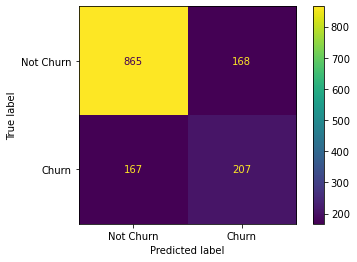

In [30]:
plot_confusion_matrix(pipe_KNN, X_test, y_test, display_labels=['Not Churn', 'Churn'])

Confusion Matrix : Confusion matrix are used to measure binary classification and multiclass classification. Binary classification only results in two output class (label), "Yes" and "No", or "0" and "1" for every data input given.

# HYPER PARAMETER TUNING (KNN)

Hyperparameter tuning is parameter value used to improve learning algorithm. Hyperparameter identify which tuple parameters will produce optimal model. To further improve our KNN model, Hyperparameter tuning will be performed. In this K-nearest neighbors we will use K = parameter which are the amount of neighbors that can be adjusted. 

Source : https://tentangdata.wordpress.com/2017/09/21/definisi-optimisasi-machine-learning/, https://codingstudio.id/hyperparameter-tuning/

In [31]:
param_KNN = {
    'algo__n_neighbors' : np.arange(1, 1000, 10), 
    'algo__weights': ['uniform','distance'], 
    'algo__p' : [1,2]  
}

In [32]:
np.arange(1, 1000, 10)

array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
       131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251,
       261, 271, 281, 291, 301, 311, 321, 331, 341, 351, 361, 371, 381,
       391, 401, 411, 421, 431, 441, 451, 461, 471, 481, 491, 501, 511,
       521, 531, 541, 551, 561, 571, 581, 591, 601, 611, 621, 631, 641,
       651, 661, 671, 681, 691, 701, 711, 721, 731, 741, 751, 761, 771,
       781, 791, 801, 811, 821, 831, 841, 851, 861, 871, 881, 891, 901,
       911, 921, 931, 941, 951, 961, 971, 981, 991])

In [33]:
skf = StratifiedKFold(n_splits=4) 

In [34]:
GSS_KNN = GridSearchCV(pipe_KNN, param_KNN, cv = skf, n_jobs=-1, verbose=1)

In [35]:
GSS_KNN.fit(X_train, y_train)

Fitting 4 folds for each of 400 candidates, totalling 1600 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         ['SeniorCitizen',
                                                                          'tenure',
                                                                          'MonthlyCharges',
                                                                          'TotalCharges']),
            

In [36]:
KNN_Tuned = GSS_KNN.best_estimator_

In [37]:
y_ts_KNN = KNN_Tuned.predict(X_test)

### Classification Report KNN

In [38]:
print(classification_report(y_test, y_ts_KNN))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1033
           1       0.61      0.61      0.61       374

    accuracy                           0.79      1407
   macro avg       0.73      0.73      0.73      1407
weighted avg       0.79      0.79      0.79      1407



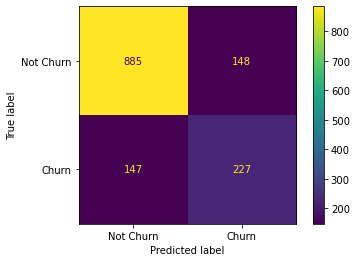

In [39]:
plot_confusion_matrix(KNN_Tuned, X_test, y_test, display_labels=['Not Churn', 'Churn'])

# Random Forest

Random Forest is a classifier that contains a number of decision trees on various subsets of the given dataset and takes the average to improve the predictive accuracy of that dataset. Instead of relying on one decision tree, the random forest takes the prediction from each tree and based on the majority votes of predictions, and it predicts the final output. The greater number of trees in the forest leads to higher accuracy and prevents the problem of overfitting.

Source : https://www.javatpoint.com/machine-learning-random-forest-algorithm

In [40]:
num_columns = ['SeniorCitizen', 'tenure', 'MonthlyCharges','TotalCharges']
cat_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
              'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'Contract', 'PaperlessBilling', 'PaymentMethod']
 

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])


categoric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown = 'ignore'))
])


preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, num_columns),
    ('categoric', categoric_pipeline, cat_columns),
])


pipe_RF = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier())
])

In [41]:
pipe_RF.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                            

### Predict Training (Random Forest)

In [42]:
RF_train = pipe_KNN.fit(X_train, y_train) 

In [43]:
z = RF_train.predict(X_train)

In [44]:
print(classification_report(y_train, z))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      4130
           1       0.72      0.65      0.69      1495

    accuracy                           0.84      5625
   macro avg       0.80      0.78      0.79      5625
weighted avg       0.84      0.84      0.84      5625



### Predict Test (Random Forest)

In [45]:
y_RF = pipe_RF.predict(X_test)

In [46]:
print(classification_report(y_test, y_RF))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.50      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.71      1407
weighted avg       0.77      0.79      0.78      1407



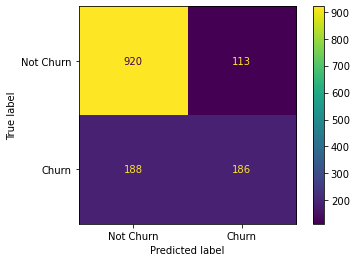

In [47]:
plot_confusion_matrix(pipe_RF, X_test, y_test, display_labels=['Not Churn', 'Churn'])

# Hyper Parameter Tuning (Random Forest)

Hyperparameter tuning is the value for the parameters used to influence the learning process. Hyperparameter performs the identification process of tuple hyperparameters which produces an optimal model that minimizes the loss function that has been determined on the independent data provided. Hyper parameter tuning in Random Forest is used to determine the optimal data using the Random Forest model with the aim of minimizing the loss function.

Source : https://tentangdata.wordpress.com/2017/09/21/definisi-optimisasi-machine-learning/, https://codingstudio.id/hyperparameter-tuning/

In [48]:
RandomForestClassifier()

RandomForestClassifier()

In [49]:
param_RF = {
    "algo__n_estimators" : np.arange(1, 1000, 10),
    "algo__max_depth" : np.arange(5, 50, 5),
    "algo__min_samples_leaf" : np.arange(1, 21, 2), 
}

In [50]:
GS_RF = GridSearchCV(pipe_RF, param_RF, cv = 3, n_jobs=-1, verbose = 3, )

In [51]:
GS_RF.fit(X_train, y_train)

Fitting 3 folds for each of 9000 candidates, totalling 27000 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         ['SeniorCitizen',
                                                                          'tenure',
                                                                          'MonthlyCharges',
                                                                          'TotalCharges']),
                                                                        

In [52]:
RF_Tuned = GS_RF.best_estimator_

In [53]:
y_RF_Tuned = RF_Tuned.predict(X_test)

### Classification Report Random Forest

In [54]:
print(classification_report(y_test, y_RF_Tuned))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.49      0.56       374

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



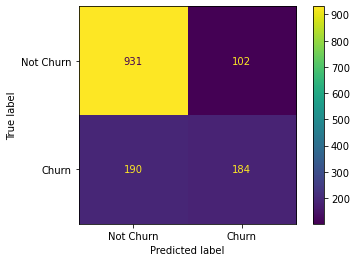

In [55]:
plot_confusion_matrix(RF_Tuned, X_test, y_test, display_labels=['Not Churn', 'Churn'])

# XGBOOST

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting that solve many data science problems in a fast and accurate way. 

Source : https://xgboost.readthedocs.io/en/stable/

In [56]:
num_columns = ['SeniorCitizen', 'tenure', 'MonthlyCharges','TotalCharges']
cat_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
              'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'Contract', 'PaperlessBilling', 'PaymentMethod']
 

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])


categoric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown = 'ignore'))
])


preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, num_columns),
    ('categoric', categoric_pipeline, cat_columns),
])


pipe_XGB = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier())
])

In [57]:
pipe_XGB.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                            

### Predict Training (XGB)

In [58]:
XGB_train = pipe_XGB.fit(X_train, y_train) 

In [59]:
z = XGB_train.predict(X_train)

In [60]:
print(classification_report(y_train, z))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4130
           1       0.91      0.85      0.88      1495

    accuracy                           0.94      5625
   macro avg       0.93      0.91      0.92      5625
weighted avg       0.94      0.94      0.94      5625



### Predict Testing (XGB)

In [61]:
y_XGB = pipe_XGB.predict(X_test)

In [62]:
print(classification_report(y_test, y_knn))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1033
           1       0.55      0.55      0.55       374

    accuracy                           0.76      1407
   macro avg       0.70      0.70      0.70      1407
weighted avg       0.76      0.76      0.76      1407



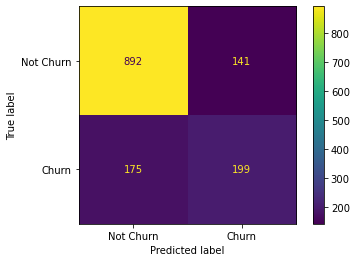

In [63]:
plot_confusion_matrix(pipe_XGB, X_test, y_test, display_labels=['Not Churn', 'Churn'])

# Hyper Parameter Tuning XGBOOST

Hyperparameter tuning is a way to optimize the model used by choosing the best parameter available. Hyperparameter identify tuple hyperparameter to obtain the most optimal model and minimize loss in the dataset. 

Source : https://tentangdata.wordpress.com/2017/09/21/definisi-optimisasi-machine-learning/, https://codingstudio.id/hyperparameter-tuning/

In [64]:
param_XGB = {
    "algo__n_estimator" : np.arange(100, 401,100),
    "algo__max_depth" : np.arange(1,6),
    "algo__learning_rate" : np.logspace(-3, 0, 4),
    "algo__gamma" : np.logspace (-3, 2, 6),
    "algo__colsample_bytree" : [0, 3, 0.5, 0.7, 0.8],
    "algo__subsample" : [0, 3, 0.5, 0.7, 0.8],
    "algo__reg_alpha" : np.logspace(-3,3,7),
    "algo__reg_lambda" : np.logspace(-3,3,7)
}

In [65]:
GS_XGB = RandomizedSearchCV(pipe_XGB, param_XGB, cv = skf, verbose = 3, n_jobs=-1)

In [66]:
GS_XGB.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[17:51:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               ['SeniorCitizen',
                                                                                'tenure',
                                                                                'MonthlyCharges',
                                            

In [67]:
GS_XGB.best_params_

{'algo__subsample': 0.8,
 'algo__reg_lambda': 0.1,
 'algo__reg_alpha': 0.01,
 'algo__n_estimator': 300,
 'algo__max_depth': 5,
 'algo__learning_rate': 0.01,
 'algo__gamma': 0.1,
 'algo__colsample_bytree': 0.5}

In [68]:
XGB_Tuned = GS_XGB.best_estimator_

In [69]:
y_XGB_Tuned = pipe_XGB.predict(X_test)

### Classification Report XGBOOST

In [70]:
print(classification_report(y_test, y_XGB_Tuned))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1033
           1       0.59      0.53      0.56       374

    accuracy                           0.78      1407
   macro avg       0.71      0.70      0.70      1407
weighted avg       0.77      0.78      0.77      1407



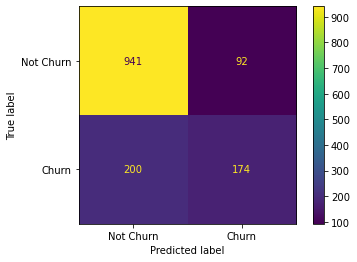

In [71]:
plot_confusion_matrix(XGB_Tuned, X_test, y_test, display_labels=['Not Churn', 'Churn'])

# LOGISTIC REGRESION

Logistic Regression is a classification algorithm to find the relationship between discrete/continuous features (input) and the probability of certain discrete output results.

In [72]:
num_columns = ['SeniorCitizen', 'tenure', 'MonthlyCharges','TotalCharges']
cat_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
              'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'Contract', 'PaperlessBilling', 'PaymentMethod']
 

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])


categoric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown = 'ignore'))
])


preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, num_columns),
    ('categoric', categoric_pipeline, cat_columns),
])


pipe_LogReg = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression())
])

In [73]:
pipe_LogReg.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                            

### Predict Train (Logistic Regression)

In [74]:
LogReg_train = pipe_LogReg.fit(X_train, y_train) 

In [75]:
z = LogReg_train.predict(X_train)

In [76]:
print(classification_report(y_train, z))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      4130
           1       0.66      0.55      0.60      1495

    accuracy                           0.80      5625
   macro avg       0.75      0.72      0.73      5625
weighted avg       0.79      0.80      0.80      5625



### Predict Test (Logistic Regression)

In [77]:
y_LogReg = pipe_LogReg.predict(X_test)

In [78]:
print(classification_report(y_test, y_knn))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1033
           1       0.55      0.55      0.55       374

    accuracy                           0.76      1407
   macro avg       0.70      0.70      0.70      1407
weighted avg       0.76      0.76      0.76      1407



# Hyper Parameter Tuning Logistic Regression

Hyperparameter tuning is parameter value used to improve learning algorithm. Hyperparameter identify which tuple parameters will produce optimal model. To further improve our Logistic Regression model, Hyperparameter tuning will be performed. Hyper parameter tuning in Logistic Regression is used to determine the optimal data using the Logistic Regression model with the aim of minimizing the loss function.

Source : https://tentangdata.wordpress.com/2017/09/21/definisi-optimisasi-machine-learning/, https://codingstudio.id/hyperparameter-tuning/

In [79]:
param_LR = {
    'algo__C' : np.logspace(-3, 3, 7),
    'algo__penalty' : ['l1', 'l2', 'lasso']
}
skf = StratifiedKFold(n_splits=4)

In [80]:
GS_logreg = GridSearchCV(pipe_LogReg, param_LR, scoring='recall', cv = skf, n_jobs=-1, verbose = True)

In [81]:
GS_logreg.fit(X_train, y_train)

Fitting 4 folds for each of 21 candidates, totalling 84 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         ['SeniorCitizen',
                                                                          'tenure',
                                                                          'MonthlyCharges',
                                                                          'TotalCharges']),
            

In [82]:
GS_logreg.best_params_

{'algo__C': 100.0, 'algo__penalty': 'l2'}

In [83]:
LR_Tuned = GS_logreg.best_estimator_

### Classification Report Logistic Regression

In [84]:
print(classification_report(y_test, LR_Tuned.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1033
           1       0.64      0.58      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



# Comparation Between Model

In [85]:
base_model= [KNN_Tuned, RF_Tuned, pipe_XGB, LR_Tuned]
model = ['KNN', 'RF', 'XGB','LogisticRegression']
data = {}

def Eva_Matrix(Model, X, y_true):
    y_pred = Model.predict(X)
    Rec = recall_score(y_true, y_pred)
    y_predict_proba = Model.predict_proba(X)[:,1]
    return Rec

for i in range(len(base_model)):
    Rec_test = Eva_Matrix(base_model[i], X_test, y_test)
    data[f'Test {model[i]}'] = Rec_test
pd.DataFrame(data = data, index = ["Recall"]).T.sort_values('Recall', ascending=False)

,Recall
Test KNN,0.606952
Test LogisticRegression,0.577540
Test XGB,0.532086
Test RF,0.502674


### Selection Of The Best Model To Determine Recommendations

We utilize 4 models (KNN , Random Forest, XGBOOST, Logistic Regression) for this Dataset, in order to know the best percentage value to determine the recommendation. In the other hand, those models are the model that are popular and powerful. In this classification report, we will focus on recall value and it's false negative result. Among the 4 models tuned, **KNN** obtained the best recall value (0.606952 = 0.61). From this model we could predict the customer's probability of churning as a recommendation for further targeted actions.

# Predict Probability

In [86]:
X_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1413,Male,0,Yes,Yes,65,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,No,No,Two year,No,Credit card (automatic),94.55,6078.75
7003,Male,0,No,No,26,No,No phone service,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Electronic check,35.75,1022.50
3355,Female,0,Yes,No,68,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,No,No,Two year,No,Credit card (automatic),90.20,6297.65
4494,Male,0,No,No,3,Yes,No,Fiber optic,No,Yes,No,No,No,Yes,Month-to-month,No,Electronic check,84.30,235.05
3541,Female,0,Yes,No,49,No,No phone service,DSL,Yes,No,No,No,Yes,No,Month-to-month,No,Bank transfer (automatic),40.65,2070.75


In [87]:
data_telco = {
    "gender" : "Female",
    "SeniorCitizen" : 0,
    "Partner" : "Yes",
    "Dependents" : "Yes",
    "tenure" : 3,
    "PhoneService" : "Yes",
    "MultipleLines" : "Yes",
    "InternetService" : "Fiber optic",
    "OnlineSecurity" : "Yes",
    "OnlineBackup" : "Yes",
    "DeviceProtection" : "Yes",
    "TechSupport" : "Yes",
    "StreamingTV" : "No",
    "StreamingMovies" : "No",
    "Contract" : "Two year",
    "PaperlessBilling" : "No",
    "PaymentMethod" : "Credit card (automatic)",
    "MonthlyCharges" : 94.55,
    "TotalCharges" : 6078.75
}

In [88]:
telco = pd.DataFrame(data_telco, index=[1])

In [89]:
GSS_KNN.predict(telco)

array([0], dtype=int64)

In [93]:
hasil = GSS_KNN.predict_proba(telco)[0][1]
hasil

0.04225352112676056

In [94]:
if hasil >= 0.7:
    print('Full retention cost: $80')
if hasil < 0.7 and hasil >= 0.3:
    print('half retention cost: $40')
else:
    print('no action needed')

no action needed


# CONCLUSION

1. The target in this analysis is recall yes because it focuses on False Negative (Actual Churn With No Predictions)
2. In telco churn data analysis, the *KNN* model is the best model with a hyperparameter tuning process with a recall positif target of 0.61
3. When using machine learning, we can find out the probability that customers will churn. which before using machine learning we give promos to all customers with the aim of maintaining potential revenue, and after using machine learning we only give promos to customers who will be predicted to churn

# RECOMENDATION

We can give offers to some people who fall into the positive recall group or predict that the actual churn will not churn, which before using machine learning we give promos to everyone, while after using the promo, we can find out which customers can be offered an offer by The goal is to reduce the churn rate for customers. The offer is given when we know the probability of customer churn is:

- if the prediction is below 0.3 then no promotion will be given
- if the prediction is above 0.3 to 0.7, the promotion will be given "Half Retention Cost = 40$"

- If the prediction is above 0.7, the promotion will be given "Full Retention Cost = 80$"